In [198]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

### Set Variables

In [199]:

ticker = 'SPY'
startDate = '2021-01-01'
endDate = '2022-12-31'
dataInterval = '1d'

# moving average period
rollingPeriod = 21

# entry ratio
entryPercentile = 0.10

# exit ratio
exitPercentile = 0.90

### Get Data

In [216]:
df = yf.download(ticker, startDate, endDate, interval = dataInterval)
df.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


### Define strategy 


    Idea: 
        Enter and Exit based on exterme price movement relative to the prior rolling min/max of close
        
    Data: 
        1. Rolling N period min and max of close 
        2. Ratio of current price relative to the rolling min/max of close
        3. The top and bottom rolling percentile of ratios
        
    Entry:
        Enter trade when price hits the top band
        
    Exit:
        Exit trade when price hits the bottom band



In [201]:
def roiBandStrategy(close_):
    # get prior highs and lows
    prior_max = max(close_)
    prior_min = min(close_)
    
    # get ratio from prior high/low
    ratio_from_high = close_[-1] / prior_max - 1
    ratio_from_low = close_[-1] / prior_min - 1
    
    
    return prior_max, prior_min, ratio_from_high, ratio_from_low

### Apply function to data

In [218]:
# apply function to data
event_date = []
close_price = []
prior_max_ = []
prior_min_ = []
ratio_from_high_ = []
ratio_from_low_ = []

queryData = list(df['Close'])
queryDate = list(df['Date']) or list(df['Dateime'])
for i in range(len(queryData)):
    
    data = queryData[i:i+rollingPeriod]
    date = queryDate[i:i+rollingPeriod]
    
    if len(data) == rollingPeriod:
        prior_max, prior_min, ratio_from_high, ratio_from_low = roiBandStrategy(data)
        
        event_date.append(date[-1])
        close_price.append(data[-1])
        
        prior_max_.append(prior_max)
        prior_min_.append(prior_min)
        ratio_from_high_.append(ratio_from_high)
        ratio_from_low_.append(ratio_from_low)


In [234]:
# get percentiles 

ratio_from_high_pct = [0] * (rollingPeriod-1)
ratio_from_low_pct = [0] * (rollingPeriod-1)

for i in range(len(ratio_from_high_)):
    
    data_high = ratio_from_high_[i:i+rollingPeriod]
    data_low = ratio_from_low_[i:i+rollingPeriod]
    
    if (len(data_high) == rollingPeriod) & (len(data_low) == rollingPeriod):
        ratio_from_high_pct.append(np.quantile(data_high, entryPercentile))
        ratio_from_low_pct.append(np.quantile(data_low, exitPercentile))
    

In [266]:
# convert list to dataframe
data = {
    'event_date': event_date,
    'close_price': close_price,
    'prior_max_': prior_max_,
    'prior_min_': prior_min_,
    'ratio_from_high_': ratio_from_high_,
    'ratio_from_low_': ratio_from_low_,
    'ratio_from_high_pct': ratio_from_high_pct,
    'ratio_from_low_pct': ratio_from_low_pct
}
data = pd.DataFrame(data)

In [ ]:
### Get bootstrapped roi means

In [ ]:
# calculate the bootstap means

iterations = 1000
boot_ratio_from_high_mean = []
boot_ratio_from_low__mean = []

for _ in range(iterations):
    boot_ratio_from_high_ = np.random.choice(data['ratio_from_high_'],replace = True, size = iterations)
    boot_ratio_from_high_mean.append(np.mean(boot_ratio_from_high_))
    
    boot_ratio_from_low_ = np.random.choice(data['ratio_from_low_'],replace = True, size = iterations)
    boot_ratio_from_low__mean.append(np.mean(boot_ratio_from_low_))
  

In [317]:
# Exit logic
data['above'] = 0
data.loc[data['ratio_from_low_'] > data['ratio_from_low_pct'],'above'] = 1
data['above_rolling5'] = data['above'].rolling(5).sum()

# if trigger was on for atleast 3 days, and trigger is off today, and the rolling roi exceeds the mean
#    exit trade tomorrow
data['entry_sell'] = 0
data.loc[(data['above_rolling5']>=3) & (data['above']==0) & (
    data['ratio_from_low_']>= np.mean(boot_ratio_from_low__mean)),'entry_sell'] = 1


# entry df
entry_sell = data[data['entry_sell']==1]

In [318]:
# # Entry logic
data['below'] = 0
data.loc[data['ratio_from_high_'] < data['ratio_from_high_pct'],'below'] = 1
data['below_rolling5'] = data['below'].rolling(5).sum()

# if trigger was on for atleast 3 days, and trigger is off today, and the rolling roi exceeds the mean
#    enter trade tomorrow

data['entry_buy'] = 0
data.loc[(data['below_rolling5']>=3) & (data['below']==0) & (
    data['ratio_from_high_'] <= np.mean(boot_ratio_from_high_mean)),'entry_buy'] = 1

# entry df
entry_buy = data[data['entry_buy']==1]


# Plot Strategy 

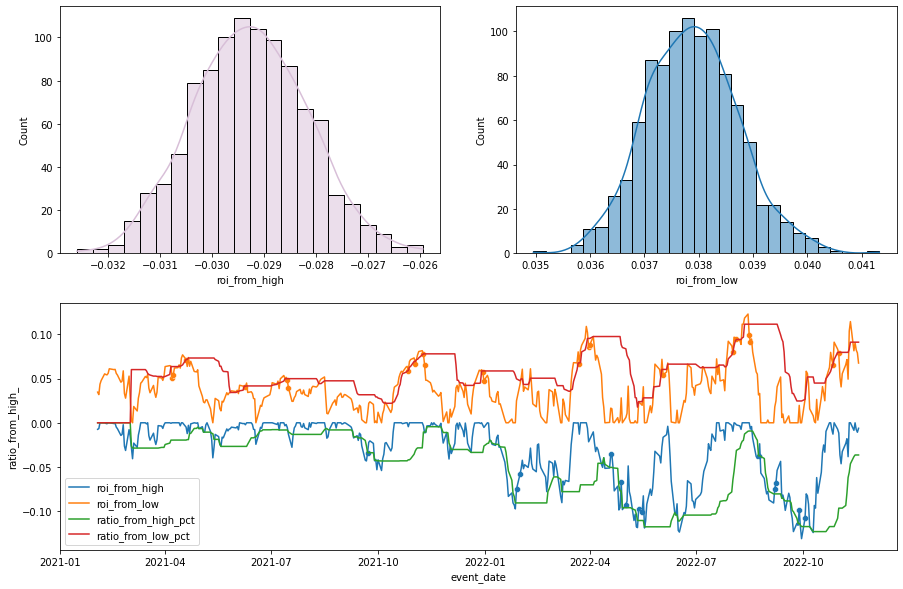

In [321]:
fig = plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.histplot(boot_ratio_from_high_mean, color= 'thistle', kde=True).set(xlabel='roi_from_high')

plt.subplot(2,2,2)
sns.histplot(boot_ratio_from_low__mean, kde=True).set(xlabel='roi_from_low')

plt.subplot(2,1,2)
sns.lineplot(x=data['event_date'],y=data['ratio_from_high_'], label='roi_from_high')
sns.lineplot(x=data['event_date'],y=data['ratio_from_low_'], label='roi_from_low')

sns.scatterplot(data=entry_buy, x="event_date", y="ratio_from_high_")
sns.scatterplot(data=entry_sell, x="event_date", y="ratio_from_low_")


sns.lineplot(x=data['event_date'],y=data['ratio_from_high_pct'], label='ratio_from_high_pct')
sns.lineplot(x=data['event_date'],y=data['ratio_from_low_pct'], label='ratio_from_low_pct')


plt.show()